# Data Retrieval

In [19]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import csv
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import itertools
import csv
import string
import pickle
import matplotlib.pyplot as plt

from collections import Counter
import re
import spacy
import nltk
from spacy.lang.en import English
from nltk.util import ngrams
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

[nltk_data] Downloading package wordnet to /Users/xzhou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/xzhou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
# Use seaborn style for plotting

plt.style.use('seaborn')

In [2]:
# File path for cities: San Francisco(sf), Okaland(ok), and Santa Clara(sc)

file_url = '/Users/xzhou/github/project_archives/files_airbnb/{}.csv'

sf_file = file_url.format('sf_airbnb/reviews')
ok_file = file_url.format('ok_airbnb/reviews')
sc_file = file_url.format('sc_airbnb/reviews')

In [3]:
# Loaded review information for each city

reviews_sf = pd.read_csv(sf_file)
reviews_ok = pd.read_csv(ok_file)
reviews_sc = pd.read_csv(sc_file)

In [4]:
print (reviews_sf.shape, reviews_ok.shape, reviews_sc.shape)

(278884, 6) (78491, 6) (135238, 6)


In [5]:
# Concatenated all files into one
# Created keys for each file for future references

frames = [reviews_sf, reviews_ok, reviews_sc]
keys = ['reviews_sf', 'reviews_ok', 'reviews_sc']
df_reviews = pd.concat(frames, keys=keys)

In [6]:
print('df_reviews dimensions: ', df_reviews.shape )
df_reviews.head()

df_reviews dimensions:  (492613, 6)


listing_id     id        date  reviewer_id reviewer_name  \
reviews_sf 0         958   5977  2009-07-23        15695      Edmund C   
           1         958   6660  2009-08-03        26145         Simon   
           2         958  11519  2009-09-27        25839         Denis   
           3         958  16282  2009-11-05        33750          Anna   
           4         958  26008  2010-02-13        15416       Venetia   

                                                       comments  
reviews_sf 0  Our experience was, without a doubt, a five st...  
           1  Returning to San Francisco is a rejuvenating t...  
           2  We were very pleased with the accommodations a...  
           3  We highly recommend this accomodation and agre...  
           4  Holly's place was great. It was exactly what I...

# Data Exploration

## Smaller Set of Features

In [7]:
df_reviews.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [8]:
# Kept only 'listing_id' and 'comments' for topic analysis

columns_to_drop=['id', 'date', 'reviewer_id', 'reviewer_name']
df_reviews.drop(columns_to_drop, axis=1, inplace=True)

In [9]:
df_reviews.shape

(492613, 2)

## Add Review Rating Feature

In [10]:
# Pull the dataset from previous step, which has the rating information

pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'
listings = pkl_file.format('df_listings_selected_features')

df_listings = pd.read_pickle(listings)

print('df_listings dimensions: :', df_listings.shape)
df_listings.head()

df_listings dimensions: : (9062, 314)


,id,host_yrs,host_response_rate,host_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,...,amenities_Shampoo,amenities_Single level home,amenities_Smoke detector,amenities_Stepfree access,amenities_TV,amenities_Wifi,amenities_translation missing enhosting_amenity_49,amenities_translation missing enhosting_amenity_50,ref_district,ref_jurisdiction
0,958,12,0.92,1,3,1.0,1.0,2.0,5.135798,1,...,1,0,1,0,1,1,0,0,San Francisco,SAN FRANCISCO
1,5858,11,1.00,2,5,1.0,2.0,3.0,5.459586,1,...,1,0,1,0,0,1,0,0,San Francisco,SAN FRANCISCO
2,7918,11,1.00,10,2,4.0,1.0,1.0,4.174387,1,...,0,0,1,0,1,1,1,1,San Francisco,SAN FRANCISCO
3,8142,11,1.00,10,2,4.0,1.0,1.0,4.174387,1,...,0,0,1,0,1,1,0,0,San Francisco,SAN FRANCISCO
4,8567,11,0.80,1,6,1.0,2.0,3.0,5.541264,0,...,1,0,1,0,1,1,0,0,San Francisco,SAN FRANCISCO


In [11]:
# Extract unique IDs from above dataset. Focus analysis on those IDs

unique_ids = df_listings.id.unique()

print('Number of unique IDs with rating: ', len(unique_ids))

Number of unique IDs with rating:  9062


In [12]:
# Filter to smaller datasets for topic analysis

df_reviews = df_reviews[df_reviews['listing_id'].isin(unique_ids)]

df_reviews.shape

(413281, 2)

In [42]:
df_listings_reviews = pd.merge(left = df_reviews, 
                               right = df_listings,
                               how = 'inner',
                               left_on='listing_id', 
                               right_on='id')

print('df_listings_reviews dimensions: ', df_listings_reviews.shape)

df_listings_reviews dimensions:  (413281, 316)


In [14]:
# Filter to smaller set of features. 
# The goal is to identify main topics within each sentiment

columns_to_keep = ['listing_id', 'review_scores_rating', 'comments']
df_reviews_smaller = df_listings_reviews[columns_to_keep]
df_reviews_smaller.head()

,listing_id,review_scores_rating,comments
0,958,97.0,"Our experience was, without a doubt, a five st..."
1,958,97.0,Returning to San Francisco is a rejuvenating t...
2,958,97.0,We were very pleased with the accommodations a...
3,958,97.0,We highly recommend this accomodation and agre...
4,958,97.0,Holly's place was great. It was exactly what I...


## Null Values

In [20]:
df_reviews_smaller.dropna(inplace=True)

In [21]:
df_reviews_smaller.isnull().sum()

listing_id              0
review_scores_rating    0
comments                0
dtype: int64

## Duplicates

In [22]:
# Drop any possible duplicate lines before saving the result

df_reviews_smaller.drop_duplicates(inplace=True)
df_reviews_smaller.shape

(412697, 3)

## Sentiment Distribution

In [48]:
# Assign sentiment score based on review ratings

def sentiment_score(x):
    """
    This is to assignment sentiment score based on rating.
    Input: ratings, ranging from 1 to 100
    Ouput: sentimant score, ranging from 0 to +1
           Postive: +1; negative: -1

    """
    if x >= 80:
        return +1
    elif x < 80:
        return 0
    else:
        return 'error'

In [49]:
# Break down ratings to positive, neutral, and negative sentiments
# This is to perform analysis for each sentiment

df_reviews_smaller['sentiment_score'] = df_reviews_smaller['review_scores_rating']  \
                                      .apply(lambda x: sentiment_score(x))

df_pos = df_reviews_smaller[df_reviews_smaller['sentiment_score']==1]
df_neg = df_reviews_smaller[df_reviews_smaller['sentiment_score']==0]

print(df_pos.shape, df_neg.shape)

(411471, 6) (1226, 6)


In [32]:
# Noted ratings scores are highly skewed. 
# Topic modeling based on positive and negative sentiment may not work as expected

df_reviews_smaller.review_scores_rating.describe (include='all')

count    412697.000000
mean         95.914017
std           3.658173
min          20.000000
25%          95.000000
50%          97.000000
75%          98.000000
max         100.000000
Name: review_scores_rating, dtype: float64

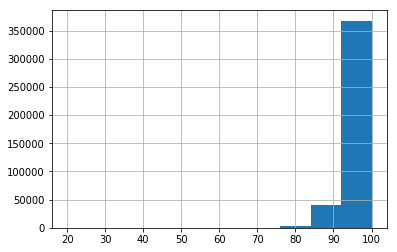

In [29]:
df_reviews_smaller.review_scores_rating.hist(bins=10)

In [51]:
# A few examples for reviews with rating < 80

df_reviews_smaller[df_reviews_smaller.review_scores_rating<80].head()

,listing_id,review_scores_rating,comments,sentiment_score,comments_words,word_count
1719,12041,75.0,Note: this review is for the Carl St. property...,0,"[Note, :, this, review, is, for, the, Carl, St...",166
1720,12041,75.0,Aaron was a great host for during my first wee...,0,"[Aaron, was, a, great, host, for, during, my, ...",156
1721,12041,75.0,I was looking for a temporary place to stay in...,0,"[I, was, looking, for, a, temporary, place, to...",144
1722,12041,75.0,This place is run like a hostel although I nev...,0,"[This, place, is, run, like, a, hostel, althou...",100
1723,12041,75.0,"Muy buena ubicación, y muy bien comunicado. El...",0,"[Muy, buena, ubicación, ,, y, muy, bien, comun...",40


## Text Preprocessing

### Review Length

In [36]:
# Break down reviews by word. 

df_reviews_smaller['comments_words'] = df_reviews_smaller['comments']  \
                                       .apply(nltk.word_tokenize)

In [37]:
# Perform word count for each review. 
# This is to remove reviews that do not have meaningful leangh

df_reviews_smaller['word_count'] = df_reviews_smaller['comments_words'].apply(len)
df_reviews_smaller.head()

,listing_id,review_scores_rating,comments,sentiment_score,comments_words,word_count
0,958,97.0,"Our experience was, without a doubt, a five st...",1,"[Our, experience, was, ,, without, a, doubt, ,...",96
1,958,97.0,Returning to San Francisco is a rejuvenating t...,1,"[Returning, to, San, Francisco, is, a, rejuven...",77
2,958,97.0,We were very pleased with the accommodations a...,1,"[We, were, very, pleased, with, the, accommoda...",149
3,958,97.0,We highly recommend this accomodation and agre...,1,"[We, highly, recommend, this, accomodation, an...",96
4,958,97.0,Holly's place was great. It was exactly what I...,1,"[Holly, 's, place, was, great, ., It, was, exa...",53


In [52]:
# Keep only comments that have meaningful length

meaningful_length = 10
df_reviews_smaller = df_reviews_smaller[
                     df_reviews_smaller['word_count'] >= meaningful_length]

df_reviews_smaller.shape

(378367, 6)

### Consolidate Reviews for Each Apartment

In [57]:
# Concolidated all reviews belong to a single 'id' to one big comment. 
# This for easier processing later on

df_consol_reviews = df_reviews_smaller  \
                    .groupby('listing_id')  \
                    .comments.apply(lambda x: ' ,'.join(x))  \
                    .reset_index()

df_consol_reviews.head()

,listing_id,comments
0,958,"Our experience was, without a doubt, a five st..."
1,3083,"B- love guest house is a pretty good place, ev..."
2,3264,The Garden Camper is totally Berkeley. It's ni...
3,5739,My wife and I were absolutely thrilled with ou...
4,5858,We had a fabulous time staying with Philip and...


In [58]:
df_consol_reviews.shape

(8950, 2)

In [61]:
df_final = pd.merge(left = df_consol_reviews, 
                    right = df_reviews_smaller, 
                    how='left', 
                    left_on ='listing_id', 
                    right_on = 'listing_id')

df_final.shape

(378367, 7)

In [62]:
df_final.head()

,listing_id,comments_x,review_scores_rating,comments_y,sentiment_score,comments_words,word_count
0,958,"Our experience was, without a doubt, a five st...",97.0,"Our experience was, without a doubt, a five st...",1,"[Our, experience, was, ,, without, a, doubt, ,...",96
1,958,"Our experience was, without a doubt, a five st...",97.0,Returning to San Francisco is a rejuvenating t...,1,"[Returning, to, San, Francisco, is, a, rejuven...",77
2,958,"Our experience was, without a doubt, a five st...",97.0,We were very pleased with the accommodations a...,1,"[We, were, very, pleased, with, the, accommoda...",149
3,958,"Our experience was, without a doubt, a five st...",97.0,We highly recommend this accomodation and agre...,1,"[We, highly, recommend, this, accomodation, an...",96
4,958,"Our experience was, without a doubt, a five st...",97.0,Holly's place was great. It was exactly what I...,1,"[Holly, 's, place, was, great, ., It, was, exa...",53


In [64]:
# Only keep one consolidated review per Listing ID

df_final.drop_duplicates(subset=['comments_x'], keep='first', inplace=True)

df_final.shape

(8949, 7)

In [67]:
# Drop columns. 'Comments-words' need to be dropped, as this is
# for individual review, not consolidated review.

columns_to_drop = ['comments_x', 'comments_words', 'word_count']
df_final.drop (columns_to_drop, axis=1, inplace=True)
df_final.head()

,listing_id,review_scores_rating,comments_y,sentiment_score
0,958,97.0,"Our experience was, without a doubt, a five st...",1
144,3083,91.0,"B- love guest house is a pretty good place, ev...",1
168,3264,90.0,The Garden Camper is totally Berkeley. It's ni...,1
203,5739,99.0,My wife and I were absolutely thrilled with ou...,1
386,5858,98.0,We had a fabulous time staying with Philip and...,1


In [68]:
df_final.rename( index=str, columns ={'comments_y': 'consol_reviews'}, inplace=True)
df_final.head()

,listing_id,review_scores_rating,consol_reviews,sentiment_score
0,958,97.0,"Our experience was, without a doubt, a five st...",1
144,3083,91.0,"B- love guest house is a pretty good place, ev...",1
168,3264,90.0,The Garden Camper is totally Berkeley. It's ni...,1
203,5739,99.0,My wife and I were absolutely thrilled with ou...,1
386,5858,98.0,We had a fabulous time staying with Philip and...,1


In [69]:
# Break down consolidated reviews by word. 

df_final['words'] = df_final['consol_reviews'].apply(nltk.word_tokenize)

In [70]:
# Store the data prior to modeling
# When there are changes, mark file_updated as true. Changes will be
# written to local files. Otherwise, mark file_updated as false. 
# Data will be loaded from existing files

file_updated = True
pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'
reviews = pkl_file.format('reviews_final')


if file_updated:
    with open(reviews, 'wb') as file:
        pd.to_pickle(df_final, file)
else:
    try: 
        with open(reviews, 'rb') as file:
            df_final = pd.read_pickle(file)
    except:
        with open(reviews, 'wb') as file:
            pd.to_pickle(df_final, file)

# Modeling

In [71]:
X = df_final['consol_reviews']

In [ ]:
# Define a topic modeling engine for intensive modeling. 
# This can help test out models and identify optimal result.

class TopicModelEngine:
    
    def __init__(self, raw_data):
        self.raw_data = raw_data

    def get_lemma(self, word):
        """
        Get the root words
        """
        try:
            lemma = wn.morphy(word)
        except:
            lemma = word
        return lemma
            
    def tokenize(self, text):
        """
        This is to perform word tokenizing. It performs ngram (1,2)
        """
        lda_tokens = []
        text=text.strip().lower()

        # Extract word portion out of sentence and excludes spaace
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(text)
        tokens = [token for token in tokens if (not token.isspace())]

        for token in tokens:
            lda_tokens.append(token)

        # Extract bigrams for additional analysis
        bigrams = ngrams(tokens, 2)

        for bg, count in Counter(bigrams).most_common():
            token_string = []
            token_string = str(bg[0]) + " " + str(bg[1])
            lda_tokens.append(token_string)

        return lda_tokens
    
    def text_processing(self, sentence, stop_words):
        """
        This is to break down text sentence into words, and 
        clean up the words to prepare for LDA modeling.
        """
    
        tokens = self.tokenize(sentence)
        tokens = [word for word in tokens if len(tokens)>5]
        tokens = [word for word in tokens if word.strip() not in stop_words]
        tokens = [self.get_lemma(word) for word in tokens]

        return tokens 
    
    def LDA_preprocessing(self, stop_words):
        """
        Provided with raw data, the proprocessing will automatically prepare and
        clean up the data, and generate necessay documents for LDA's use.
        """
        self.text_data = []

        for line in self.raw_data:
            tokens = self.text_processing(line, stop_words)
            tokens=[token for token in tokens if token is not None]
            self.text_data.append(tokens)
        
        # Create Dictionary
        self.dictionary = corpora.Dictionary(self.text_data)
        # Term Document Frequency
        self.corpus = [self.dictionary.doc2bow(text) for text in self.text_data]

    def LDA_model(self, num_of_topics, num_passes, stop_words):
        """
        This is to perform topic modeling and save the model under the name
        user provides
        """
        self.LDA_preprocessing(stop_words)
        num_topics = num_of_topics
        self.lda = LdaModel(corpus=self.corpus,  
                            num_topics=num_topics, 
                            id2word=self.dictionary, 
                            passes=num_passes) 
        
        #self.lda_corpus = self.lda(self.corpus)
        
        #self.lda.save(file_name_to_save_as)
        
        return self.lda
    
    def print_topics(self, num_of_words):
        """
        Print out topics for users's decision making. 
        User can specify number of words to print out
        """
        topics = self.lda.print_topics(num_words=num_of_words)
        for topic in topics:
            print('Topic ' + str(topic[0]+1)+': '+str(topic[1]))
            
    def word_cloud(self, num_of_topics):
        for topic in range(num_of_topics):
            plt.figure(figsize=(14,8))
            plt.imshow(WordCloud().fit_words(dict(self.lda.show_topic(topic, 200))))
            plt.axis("off")
            plt.title("Topic #" + str(topic))
            plt.show()

In [ ]:
# Default stop_words
stop_words = set(stopwords.words('English'))

In [ ]:
# This is to add additional words to default stop words
# Additional words: through multiple iterations, addtional stop words were identified
# Default stop: provided by nltk

additional_words_to_exclude = set(['get', 'one', 'say', 'still', 'try', 'david', 'john',
                                   'good', 'area', 'oakland','recommend', 'nice', 'la', 'area',
                                   'also', 'thing', 'michael', 'stay', 'us', 'de', 'place', 
                                   'house', 'great','enjoy','tings', 'another','maybe','around',
                                  'santa', 'perfect', 'love', 'well', 'feel', 'amaze', 'even',
                                  'definitely', 'check', 'make', 'like', 'take', 'back', 'felt',
                                  'really', 'need', 'highly', 'lovely'])

In [ ]:
# Add additional words to default stop words

total_words_to_exclude = stop_words.union(additional_words_to_exclude)

In [ ]:
# Identify top 3 topics

topics_3 = TopicModelEngine(X)
lda_3 = topics_3.LDA_model(num_of_topics=3, 
                              num_passes=10,
                              stop_words=total_words_to_exclude)
topics_3.print_topics(num_of_words=10)

In [ ]:
topics_3.word_cloud(num_of_topics=3)

In [ ]:
# Find out topic for each individual review

for i in lda_3.get_document_topics(topics_3.corpus):
    print (i)

In [ ]:
# Identify top 5 topics

topics_5 = TopicModelEngine(X)
lda_5 = topics_5.LDA_model(num_of_topics=5, 
                              num_passes=10,
                              stop_words=total_words_to_exclude)
topics_5.print_topics(num_of_words=10)

In [ ]:
topics_5.word_cloud(num_of_topics=5)

In [ ]:
# Identify top 10 topics

topics_10 = TopicModelEngine(X)
lda_10 = topics_10.LDA_model(num_of_topics=10, 
                              num_passes=10,
                              stop_words=total_words_to_exclude)
topics_10.print_topics(num_of_words=10)

In [ ]:
topics_10.word_cloud(num_of_topics=10)